# Import

In [21]:
# Numpy, matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Stable baselines
import gymnasium as gym
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback

# Custom modules
import sys
import os
local_path = '/Users/riccardo/Documents/GitHub/' #'path_to_progect_folder/'
sys.path.append(local_path+'OptimalControlAttacks/SyntheticDataExperiments/')
from Modules import AuxiliaryFunctions as AF
from Modules import GreedyAttacks as GA
from Modules import DeepRLAttacks as RLA
from Parameters import ParametersAttacksComparison_SigmoidalPerceptron as Par

# Colors

In [2]:
orange = '#F5A962'
light_blue = '#3C8DAD'

# Parameters

In [3]:
# Activation
activation = Par.activation

# Input data parameters
dim_input = Par.dim_input
batch_size = Par.batch_size
mu_x = Par.mu_x
sigma_x = Par.sigma_x
n_runs_experiments = Par.n_runs_experiments

# Dynamics parameters
learning_rate = Par.learning_rate
gamma = Par.gamma
beta = Par.beta

# N. samples
n_timesteps = Par.n_timesteps
n_timesteps_transient_th = Par.n_timesteps_transient_th
n_timesteps_past = Par.n_timesteps_past
n_samples_average = Par.n_samples_average
n_samples_buffer = Par.n_samples_buffer
n_samples_test = Par.n_samples_test
time_window = Par.time_window

# Control parameters
a_min = Par.a_min
a_max = Par.a_max
n_a_gridpoints = Par.n_a_gridpoints
n_runs_calibration = Par.n_runs_calibration
control_cost_weight = Par.control_cost_weight
greedy_weight_future = Par.greedy_weight_future
opt_pref = Par.opt_pref
fut_pref = Par.fut_pref

# DeepRL Agent
agent_model_name = Par.agent_model_name
n_actions = Par.n_actions
use_action_noise = Par.use_action_noise
action_noise_mean = Par.action_noise_mean
action_noise_std = Par.action_noise_std
use_small_achitecture = Par.use_small_achitecture
randomise_initial_condition = Par.randomise_initial_condition
shuffle_array = Par.shuffle_array
learning_rate_agent = Par.learning_rate_agent
activation_fn = Par.activation_fn
n_episodes = Par.n_episodes
save_freq = Par.save_freq
train_freq = Par.train_freq

# Strings/paths
experiment_description = Par.experiment_description
path_agent = Par.path_agent
export_path = Par.export_path
rlmodels_path = Par.rlmodels_path

In [4]:
print('dim_input:', dim_input)
print('batch_size:', batch_size)
print('activation:', activation)
print('a min:', a_min)
print('a max:', a_max)
print('control_cost_weight:', control_cost_weight)
print('N past timesteps:', n_timesteps_past)

dim_input: 10
batch_size: 1
activation: Erf
a min: -2
a max: 3
control_cost_weight: 1.0
N past timesteps: 40000


# Arrays

In [5]:
# Teacher
w_teach = np.ones(dim_input) #np.random.normal(0, 1, dim_input)
w_teach = w_teach/(np.sum(w_teach**2)/dim_input)**0.5
# Target
w_target = -w_teach
# Student (initial condition)
w_stud_0 = w_teach
            
# Arrays (assuming batch_size as specified above)
x_incoming_arr = np.random.normal(mu_x, sigma_x, (n_runs_experiments, batch_size*n_timesteps, dim_input))
x_past = np.random.normal(mu_x, sigma_x, (batch_size*n_timesteps_past, dim_input))
x_buffer = np.random.normal(mu_x, sigma_x, (batch_size*n_samples_buffer, dim_input))
x_test = np.random.normal(mu_x, sigma_x, (batch_size*n_samples_test, dim_input))

# Weight action cost

In [7]:
input_t_test = np.dot(w_teach, x_test.T)/(dim_input**0.5)
input_o_test = np.dot(w_target, x_test.T)/(dim_input**0.5)
label_t_test = GA.perceptron(input_t_test, activation=activation)
label_o_test = GA.perceptron(input_o_test, activation=activation)
error_target_teach = np.mean((label_o_test-label_t_test)**2)
d_target_teach = 0.5 * error_target_teach
pref_control_cost_weight = (2*d_target_teach)
print('Pre-factor control cost: %.2f' % pref_control_cost_weight)

Pre-factor control cost: 1.32


## Check environment

In [8]:
print('Shuffle past stream:', shuffle_array)
print('Randomise initial condition:', randomise_initial_condition)
env = RLA.EnvironmentPerceptron(x_arr=x_past, 
                                batch_size=batch_size,
                                w_stud_0=w_stud_0,
                                w_teach=w_teach, 
                                w_target=w_target, 
                                a_min=a_min,
                                a_max=a_max,
                                learning_rate=learning_rate, 
                                control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                                activation=activation,
                                shuffle_array=shuffle_array, 
                                randomise_initial_condition=randomise_initial_condition)

check_env(env, warn=True)

Shuffle past stream: True
Randomise initial condition: False


/opt/anaconda3/envs/OptimalControlAttacks/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:428: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


# RL agent

In [10]:
# Small architecture
if use_small_achitecture:
    print('Using custom small architecture for policy and value!')
    custom_net_kwargs = dict(activation_fn=activation_fn, net_arch=dict(pi=[10, 10], qf=[10, 10]))
else:
    custom_net_kwargs = None
         
# Create model
if agent_model_name=='TD3':
    
        if use_action_noise:
            action_noise = NormalActionNoise(mean=action_noise_mean, sigma=action_noise_std)
        else:
            action_noise = None  
            
        model = TD3("MlpPolicy", 
                    env,
                    action_noise=action_noise,
                    verbose=0, 
                    gamma=gamma,
                    learning_rate=learning_rate_agent, 
                    policy_kwargs=custom_net_kwargs,
                    train_freq=train_freq, 
                    gradient_steps=train_freq)
        print('New %s agent created' % agent_model_name)
else:
    raise ValueError('Agent type other than TD3 not available/tested')

New TD3 agent created


# Training agent

In [12]:
print('timesteps for each episode:', n_timesteps_past)

# Save a checkpoint 
checkpoint_callback = CheckpointCallback(
  save_freq=save_freq,
  save_path=path_agent,
  name_prefix="rl_model",
  save_replay_buffer=False,
  save_vecnormalize=True,
)

for ep in range(n_episodes):
    print('Episode: %d/%d'%(ep+1, n_episodes))
    model.learn(total_timesteps=n_timesteps_past, 
                progress_bar=False, 
                reset_num_timesteps=False,
                tb_log_name='DeepRL', 
                log_interval=1, 
                callback=checkpoint_callback)
        
print('Training completed!')

timesteps for each episode: 40000
Episode: 1/8
Episode: 2/8
Episode: 3/8
Episode: 4/8
Episode: 5/8
Episode: 6/8
Episode: 7/8
Episode: 8/8
Training completed!


## Compute training performance

In [13]:
timesteps = n_timesteps_past

steps = []
rew_disc_av = []

# Test environmet
env = RLA.EnvironmentPerceptron(x_arr=x_test,
                                batch_size=batch_size,
                                w_stud_0=w_stud_0, 
                                w_teach=w_teach, 
                                w_target=w_target, 
                                a_min=a_min,
                                a_max=a_max,
                                learning_rate=learning_rate, 
                                control_cost_weight=pref_control_cost_weight*control_cost_weight, 
                                activation=activation, 
                                randomise_initial_condition=randomise_initial_condition, 
                                shuffle_array=shuffle_array)

# Testing
for ep in range(n_episodes):
    
    for t in range(0, timesteps+1, save_freq):
        
        timesteps_past = ep*timesteps + t
        steps_flag = False

        if agent_model_name=='TD3':
            path_to_model = path_agent + f'/rl_model_{timesteps_past}_steps.zip'
            #path_to_buffer = path_repbuffer + f'rl_model_replay_buffer_{timesteps_past}_steps.pkl'
            if os.path.exists(path_to_model):
                model_iter = TD3.load(path_to_model, env)
                #model_iter.load_replay_buffer(path_to_buffer)
                print('Model: %d steps (episode %d)' % (timesteps_past, ep+1)) 
                steps_flag = True
            else:
                print('Model not found: %d steps (episode %d)' % (timesteps_past, ep+1)) 

        if steps_flag:
            reward_list = []
            obs, info = env.reset()
            terminated = False
            while not terminated:
                action, _ = model_iter.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                if env.timestep>=n_timesteps - time_window:
                    reward_list.append(reward)
                    
            rew_disc_av.append(np.mean(np.array(reward_list, dtype=object)))
            steps.append(timesteps_past)
        
objective = -np.array(rew_disc_av, dtype=object)
steps = np.array(steps, dtype=object)

Model not found: 0 steps (episode 1)
Model: 1000 steps (episode 1)
Model: 2000 steps (episode 1)
Model: 3000 steps (episode 1)
Model: 4000 steps (episode 1)
Model: 5000 steps (episode 1)
Model: 6000 steps (episode 1)
Model: 7000 steps (episode 1)
Model: 8000 steps (episode 1)
Model: 9000 steps (episode 1)
Model: 10000 steps (episode 1)
Model: 11000 steps (episode 1)
Model: 12000 steps (episode 1)
Model: 13000 steps (episode 1)
Model: 14000 steps (episode 1)
Model: 15000 steps (episode 1)
Model: 16000 steps (episode 1)
Model: 17000 steps (episode 1)
Model: 18000 steps (episode 1)
Model: 19000 steps (episode 1)
Model: 20000 steps (episode 1)
Model: 21000 steps (episode 1)
Model: 22000 steps (episode 1)
Model: 23000 steps (episode 1)
Model: 24000 steps (episode 1)
Model: 25000 steps (episode 1)
Model: 26000 steps (episode 1)
Model: 27000 steps (episode 1)
Model: 28000 steps (episode 1)
Model: 29000 steps (episode 1)
Model: 30000 steps (episode 1)
Model: 31000 steps (episode 1)
Model: 3200

## Export training performance

In [14]:
models_description = '_agent#%s' % (agent_model_name)
name = 'ObjectiveVSTrainingSteps'
filename = name + '_@@@' + models_description + experiment_description
data_to_export = objective
np.save(rlmodels_path + filename, data_to_export)


models_description = '_agent#%s' % (agent_model_name)
name = 'TrainingSteps'
filename = name + '_@@@' + models_description + experiment_description
data_to_export = steps
np.save(rlmodels_path + filename, data_to_export)

## Plot training performance

In [15]:
# Greedy average reward
if activation=='Linear':
    pref_fut = 1.
elif activation=='Erf':
    pref_fut = 2.
reward_greedy_list = []

# Greedy experiment
obs, info = env.reset()
w_stud = env.w_stud
x_batch = env.x_batch
terminated = False
while not terminated:    
    action = GA.a_greedy_perceptron(w_stud=w_stud,
                                    w_target=w_target,
                                    w_teach=w_teach,
                                    x_batch=x_batch,
                                    x_buffer=x_buffer,
                                    dim_input=dim_input,
                                    eta=learning_rate,
                                    weight_future=pref_fut*dim_input/learning_rate,
                                    a_min=a_min,
                                    a_max=a_max,
                                    control_cost_weight=pref_control_cost_weight*control_cost_weight,
                                    activation=activation)
    
    obs, reward, terminated, truncated, info = env.step(action)
    w_stud = env.w_stud
    x_batch = env.x_batch
    if env.timestep>=n_timesteps - time_window:
        reward_greedy_list.append(reward)
    
objective_greedy = -np.mean(np.array(reward_greedy_list, dtype=object))
objective_greedy, env.timestep

(0.22018175761658085, 9999)

In [16]:
# Find best model
best_model_t = steps[np.argmin(objective)]
best_model_obj = objective[np.argmin(objective)]
best_model_t, best_model_obj

(274000, 0.22906867431559627)

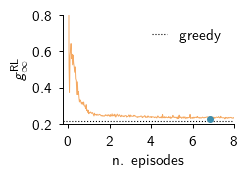

In [18]:
AF.SetPlotParams(magnification=.9, ratio=float(2.2/3.), fontsize=11, lines_w=.7, ms=7)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')


plt.axhline(objective_greedy, color='black', ls=':', lw=.8, label='greedy')
plt.plot(steps+1, objective, color=orange)
plt.plot(best_model_t, best_model_obj, color=light_blue, ls='', marker='.', ms=8)

plt.ylabel('$g^{\mathrm{RL}}_{\infty}$')
plt.xlabel('n. episodes')
plt.xlim([-n_timesteps_past/4, n_episodes*n_timesteps_past])
x_positions_ticks = np.linspace(0, n_episodes, n_episodes//2+1)*n_timesteps_past
x_ticks_labels = [int(x) for x in np.linspace(0, n_episodes, n_episodes//2+1)]
plt.xticks(x_positions_ticks, x_ticks_labels)
plt.yticks([0.2, 0.4, 0.6, 0.8])
plt.ylim([0.2, .8])
plt.grid(False)
plt.legend(loc=0)
plt.show()

# Plot 1D policy

In [20]:
if dim_input==1 and batch_size==1:
    
    ########################
    #     Choose model     #
    ########################
    
    timesteps_past = best_model_t
    if agent_model_name=='TD3':
        path_to_model = path_agent + f'/rl_model_{timesteps_past}_steps.zip'
        #path_to_buffer = path_repbuffer + f'rl_model_replay_buffer_{timesteps_past}_steps.pkl'
        if os.path.exists(path_to_model):
            model_iter = TD3.load(path_to_model, env)
            #model_iter.load_replay_buffer(path_to_buffer)
            print('%d (ep %d)' % (timesteps_past, ep+1)) 
            steps_flag = True
        else:
            print('  %d-model not found (ep %d)' % (timesteps_past, ep+1)) 

    AF.SetPlotParams(magnification=1.6, ratio=float(2.2/3.), fontsize=12, lines_w=1.3, ms=7)
    mpl.rc('text', usetex = True)
    mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')

    
    ########################
    #        3D Plot       #
    ########################
    
    #******  Evaluate policy functions  ******#
    n_rho_values = 60
    rho_grid = np.linspace(0., 1., n_rho_values)
    n_x_values = 60
    x_grid = np.linspace(-3, 3, n_x_values)
    a_greedy_grid_2D = np.zeros((n_rho_values, n_x_values))
    a_DeepRL_grid_2D = np.zeros((n_rho_values, n_x_values))
    for j, rho in enumerate(rho_grid):
        print('Line: %d/%d' % (j+1, n_rho_values))
        w_stud_val = w_teach * (1-rho) + w_target * rho
        a_greedy_grid = np.zeros_like(x_grid)
        a_DeepRL_grid = np.zeros_like(x_grid)
        for i, x in enumerate(x_grid):
            x_batch = np.array([[x]], dtype=np.float32)
            obs = np.concatenate((w_stud_val.reshape(1,-1), x_batch), axis=0, dtype=np.float32).flatten()
            a_DeepRL_grid[i], _ = model_iter.predict(obs, deterministic=True)
            a_greedy_grid[i] = GA.a_greedy_perceptron(w_stud=w_stud_val,
                                                      w_target=w_target,
                                                      w_teach=w_teach,
                                                      x_batch=x_batch,
                                                      x_buffer=x_buffer,
                                                      dim_input=dim_input,
                                                      eta=learning_rate,
                                                      weight_future=pref_fut*dim_input/learning_rate,
                                                      a_min=a_min,
                                                      a_max=a_max,
                                                      control_cost_weight=pref_control_cost_weight*control_cost_weight,
                                                      activation=activation)
        a_greedy_grid_2D[j] = a_greedy_grid
        a_DeepRL_grid_2D[j] = a_DeepRL_grid
        
    
    #******  Greedy policy  ******#
    ax = plt.figure().add_subplot(projection='3d')
    alpha = 0.8
    
    x = x_grid
    for j, rho in enumerate(rho_grid):
        y = 1-rho * np.ones_like(x)
        z = a_greedy_grid_2D[j]
        ax.plot(x, y, z, color=light_blue, alpha=alpha)
        ax.set(xlabel='x', ylabel='$\\rho$', zlabel='a')
        ax.set_zlabel('a')

    # Remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    # Set color of edges
    ax.xaxis.pane.set_edgecolor('grey')
    ax.yaxis.pane.set_edgecolor('grey')
    ax.zaxis.pane.set_edgecolor('grey')
    ax.grid(False)
    # Save figure
    #filename = 'Policy1DGreedy#%s.pdf' % activation
    #plt.savefig(path_figures + filename, bbox_inches='tight')
    plt.show()
    
    
    #******  RL agent policy  ******#
    ax = plt.figure().add_subplot(projection='3d')
    
    for j, rho in enumerate(rho_grid):
        y = 1-rho * np.ones_like(x)
        z = a_DeepRL_grid_2D[j]
        ax.plot(x, y, z, color=orange, alpha=alpha)
        ax.set(xlabel='x', ylabel='$\\rho$', zlabel='a')
        ax.set_zlabel('a')

    # Remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    # Set color of edges
    ax.xaxis.pane.set_edgecolor('grey')
    ax.yaxis.pane.set_edgecolor('grey')
    ax.zaxis.pane.set_edgecolor('grey')
    ax.grid(False)
    # Save figure
    #filename = 'Policy1DRL#%s.pdf' % activation
    #plt.savefig(path_figures + filename, bbox_inches='tight')
    plt.show()